In [2]:
import pyglet
import pyrender
import numpy as np
import trimesh
import matplotlib
import matplotlib.pyplot as plt
plt.style.use('default')
import open3d as o3d
import time
import sys,os

from scipy.spatial import KDTree
from scipy.sparse import diags
from scipy.sparse.linalg import svds

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


(19970, 3)
(39936, 3)


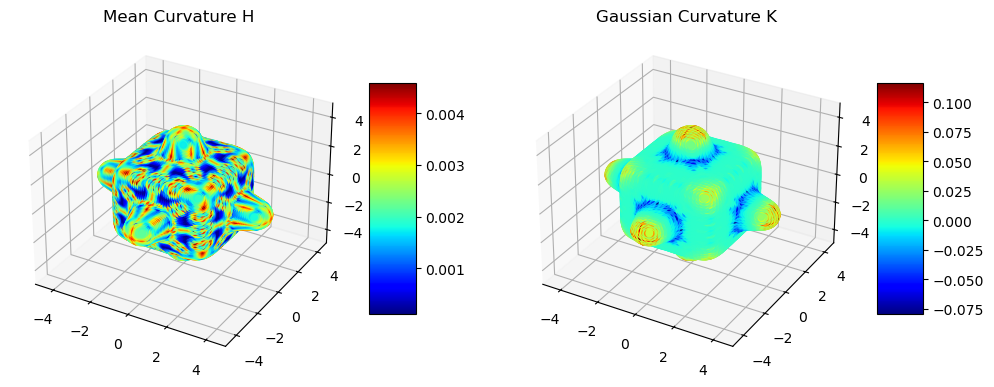

Mean Curvature H: [0.00104645 0.00256149 0.00256149 ... 0.00166876 0.00265517 0.00241607]
Gaussian Curvature K: [ 0.03381287 -0.00647606 -0.00647606 ... -0.01143512 -0.00723472
 -0.01146559]


In [18]:
RES_PATH = 'meshes'
mesh_src = os.path.join(RES_PATH, 'bumpy-cube.obj')
assert os.path.exists(mesh_src), 'cannot found:' + mesh_src
from mpl_toolkits.mplot3d import Axes3D

# 使用 trimesh 加载网格
mesh = trimesh.load(mesh_src)
# 获取顶点和面
vertices = np.array(mesh.vertices)
faces = np.array(mesh.faces)
print(vertices.shape)
print(faces.shape)

# 函数计算每个顶点的邻居
def get_vertex_neighbors(faces):
    vertex_neighbors = {}
    for face in faces:
        for i in range(3):
            if face[i] not in vertex_neighbors:
                vertex_neighbors[face[i]] = []
            # 这里将NumPy数组转换为列表进行连接操作,合并当前顶点前面和后面的点
            vertex_neighbors[face[i]].extend(list(face[:i]) + list(face[i+1:]))
            # print(face)
            # print(i, face[i], face[:i], face[i+1:])
    # 删除重复项
    for vertex in vertex_neighbors:
        vertex_neighbors[vertex] = list(set(vertex_neighbors[vertex]))
    return vertex_neighbors

# 计算每个顶点的均质曲率H
def compute_mean_curvature(vertices, vertex_neighbors):
    H = np.zeros(len(vertices))
    for i in range(len(vertices)):
        if i not in vertex_neighbors: continue
        neighbor_vectors = vertices[vertex_neighbors[i]] - vertices[i]
        # print(i, vertex_neighbors[i])
        L = np.sum(neighbor_vectors, axis=0) / len(neighbor_vectors)
        H[i] = np.linalg.norm(L) / 2
    return H

import numpy as np
import trimesh
import os

# Helper function to calculate the circumcenter of a triangle in 3D
def circumcenter(A, B, C):
    ac = C - A 
    ab = B - A 
    ab_cross_ac = np.cross(ab, ac)
    
    # Compute the circumcenter in 3D
    circumcenter = A + (np.cross(ab_cross_ac, ab) * np.linalg.norm(ac)**2 - np.cross(ab, ab_cross_ac) * np.linalg.norm(ac)**2) / (2 * np.linalg.norm(ab_cross_ac)**2)
    return circumcenter

# Helper function to check if a triangle is obtuse
def is_obtuse_triangle(A, B, C):
    # Check if a triangle is obtuse by comparing the squares of its sides
    a2 = np.linalg.norm(C - B)**2
    b2 = np.linalg.norm(C - A)**2
    c2 = np.linalg.norm(B - A)**2
    return a2 + b2 < c2 or a2 + c2 < b2 or b2 + c2 < a2

# Function to calculate mixed cell Gaussian curvature
def mixed_cells_gaussian_curvature(vertices, faces):
    # Initialize area and angle deficit for each vertex
    voronoi_areas = np.zeros(len(vertices))
    angle_deficits = 2 * np.pi * np.ones(len(vertices))

    # Calculate the Voronoi area and angle deficit for each vertex
    for face in faces:
        A, B, C = vertices[face]
        # Check if the triangle is obtuse
        is_obtuse = is_obtuse_triangle(A, B, C)

        # Compute the circumcenter for non-obtuse triangles
        if not is_obtuse:
            circum_center = circumcenter(A, B, C)

        # Calculate Voronoi area for each vertex in the face
        for i, vertex in enumerate(face):
            opposite_edge = np.delete(face, i)
            edge_midpoint = np.mean(vertices[opposite_edge], axis=0)

            if is_obtuse:
                # For obtuse triangle, use midpoint of the edge opposite the obtuse angle
                voronoi_areas[vertex] += np.linalg.norm(edge_midpoint - vertices[vertex]) / 2
            else:
                # For non-obtuse triangle, use circumcenter
                if circum_center is not None:
                    voronoi_areas[vertex] += np.linalg.norm(circum_center - vertices[vertex]) / 2

            # Compute the angle at vertex
            vec1, vec2 = vertices[opposite_edge[0]] - vertices[vertex], vertices[opposite_edge[1]] - vertices[vertex]
            angle = np.arccos(np.clip(np.dot(vec1, vec2) / (np.linalg.norm(vec1) * np.linalg.norm(vec2)), -1, 1))
            angle_deficits[vertex] -= angle

    # Compute Gaussian curvature
    gaussian_curvature = angle_deficits / voronoi_areas
    gaussian_curvature[np.isnan(gaussian_curvature)] = 0  # Handle NaN values

    return gaussian_curvature


# 可视化曲率
def visualize_curvature(vertices, H, K):
    fig = plt.figure(figsize=(12, 6))

    # 可视化均质曲率H
    ax1 = fig.add_subplot(121, projection='3d')
    ax1.set_title("Mean Curvature H")
    scatter = ax1.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=H, cmap='jet')
    fig.colorbar(scatter, ax=ax1, shrink=0.5, aspect=5)

    # 可视化高斯曲率K
    ax2 = fig.add_subplot(122, projection='3d')
    ax2.set_title("Gaussian Curvature K")
    scatter = ax2.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c=K, cmap='jet')
    fig.colorbar(scatter, ax=ax2, shrink=0.5, aspect=5)

    plt.show()


# 获取每个顶点的邻居3q
vertex_neighbors = get_vertex_neighbors(faces)
# 计算均质曲率H和高斯曲率K
H = compute_mean_curvature(vertices, vertex_neighbors)
K = mixed_cells_gaussian_curvature(vertices, faces)

visualize_curvature(vertices, H, K)
# 输出结果（这里只是打印出来，您可能需要将它们保存到文件或以其他方式处理）
print("Mean Curvature H:", H)
print("Gaussian Curvature K:", K)
